# ScatteringNet – Predicting Particle Radius from Simulated Scattering Profiles Using Neural Networks

This project presents a prototype for applying machine learning—specifically neural networks—to analyze synthetic small-angle X-ray scattering (SAXS) data and extract meaningful physical parameters.

## Objective
The main goal is to predict the radius of spherical nanoparticles directly from their 1D scattering profiles using a fully connected neural network. While the data used here is simulated using a simplified exponential model, it approximates realistic SAXS behavior and serves as a proof-of-concept for more complex experimental scenarios.

## Scientific Context
Scattering techniques such as SAXS, GISAXS, and GIWAXS are widely used in materials science and soft matter physics to infer structural features including:
- Particle size and shape
- Interparticle spacing
- Aggregation behavior
- Ordering and correlation length

However, interpreting scattering data often requires computationally expensive fitting or complex analytical modeling. This project aims to explore how data-driven models can provide faster, approximate, and automated insights into scattering-based measurements.

## Why Neural Networks?
Neural networks are capable of learning complex relationships in high-dimensional data. In this project, we implement a shallow feedforward neural network (Multi-Layer Perceptron) as an initial approach:
- Input: 1D scattering profile (200 q-points)
- Output: Scalar particle radius
- Architecture: Three fully connected layers with ReLU activations
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam

This architecture is intentionally kept simple for interpretability. It can later be extended to:
- 1D Convolutional Neural Networks (CNNs) for better pattern recognition
- Multi-output regression for simultaneous prediction of multiple physical parameters
- Integration with real experimental data containing noise and background artifacts

## Motivation
This notebook serves as a foundational prototype for applying machine learning to interpret scattering data in a physical context. While the data is simulated, the methodology is directly translatable to real-world GISAXS/SAXS analysis pipelines. Future versions will explore physics-aware simulation, real experimental validation, and more advanced neural architectures.


## Step 1 – Simulating Scattering Profiles

In this section, we generate synthetic 1D scattering profiles that mimic the behavior of real small-angle X-ray scattering (SAXS) data. 
Each profile is based on a simplified exponential function and corresponds to a specific particle radius. 
We add Gaussian noise to simulate experimental imperfections.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# q-range for simulated scattering
q = np.linspace(0.01, 1.0, 200)

# Simulate 1D SAXS-like profile with noise
def generate_sample(radius):
    intensity = np.exp(-(q * radius)**2)
    noise = np.random.normal(0, 0.01, size=q.shape)
    return intensity + noise

# Generate dataset
X = []
y = []

for _ in range(500):
    r = np.random.uniform(2, 10)
    X.append(generate_sample(r))
    y.append(r)

X = np.array(X)
y = np.array(y).reshape(-1, 1)


## Step 2 – Data Normalization and Splitting

We normalize both the input data (scattering profiles) and the target variable (particle radius) using MinMax scaling. 
This helps the neural network train more effectively. 
Then, we split the dataset into training and test sets using an 80/20 ratio.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize input and output
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


## Step 3 – Building the Neural Network

Here, we define a simple feedforward neural network using PyTorch. 
The model takes 1D scattering data as input and predicts the corresponding particle radius. 
The architecture consists of three fully connected layers with ReLU activations, optimized using the Adam optimizer and MSE loss.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define a simple feedforward neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(200, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Model, loss function, optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Step 4 – Training the Model

We train the model for 100 epochs on the training data. 
The loss is calculated using Mean Squared Error (MSE), and the optimizer updates the weights via backpropagation. 
Training loss is recorded at each epoch for later visualization.


In [4]:
train_losses = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 0.1017
Epoch 20, Loss: 0.0122
Epoch 30, Loss: 0.0037
Epoch 40, Loss: 0.0021
Epoch 50, Loss: 0.0015
Epoch 60, Loss: 0.0014
Epoch 70, Loss: 0.0013
Epoch 80, Loss: 0.0012
Epoch 90, Loss: 0.0011
Epoch 100, Loss: 0.0011


## Step 5 – Evaluation and Visualization

After training, we evaluate the model on the test set and visualize its performance. 
We compare the predicted radii with the ground truth values using a scatter plot. 
We also plot the training loss over epochs to observe convergence behavior.


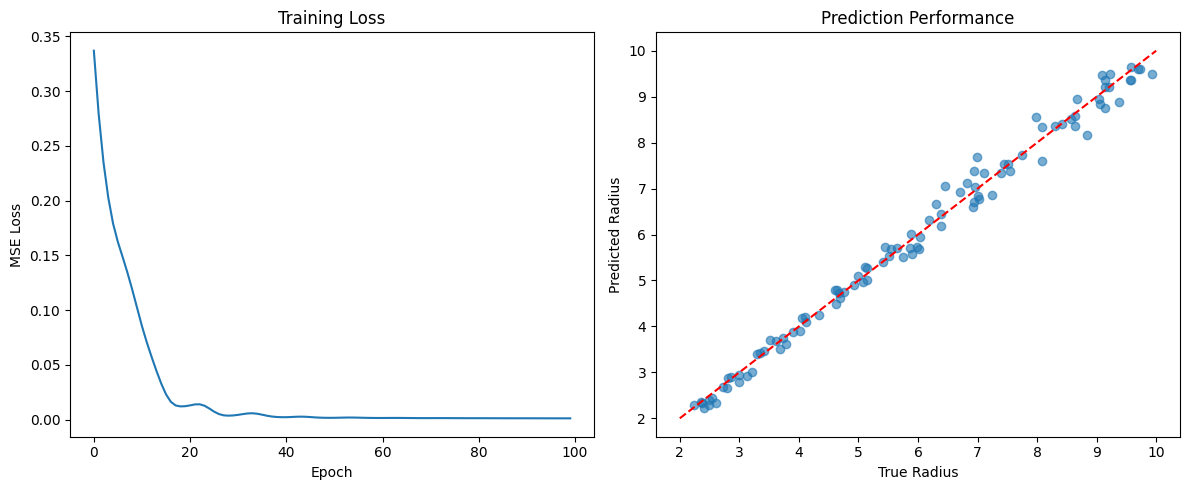

In [10]:
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).numpy()
    preds_rescaled = y_scaler.inverse_transform(preds)
    y_test_rescaled = y_scaler.inverse_transform(y_test_tensor.numpy())

# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# Scatter plot: True vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test_rescaled, preds_rescaled, alpha=0.6)
plt.plot([2, 10], [2, 10], 'r--')  # perfect prediction line
plt.xlabel("True Radius")
plt.ylabel("Predicted Radius")
plt.title("Prediction Performance")

plt.tight_layout()
plt.show()


## Step 6 – Discussion and Future Work

### Limitations:
- The synthetic scattering data is based on a highly simplified exponential model. Real experimental data (e.g. GISAXS or SAXS) would include more complex features such as form factors, structure factors, background noise, and instrumental artifacts.
- The model is trained on noise-added but still cleanly generated data. Generalization to real-world noisy data is untested.
- Only one physical parameter (particle radius) is predicted. In real scenarios, multiple parameters (e.g. polydispersity, shape, interparticle spacing) may need to be inferred simultaneously.

### Potential Improvements:
- Use real experimental scattering datasets to validate and fine-tune the model.
- Incorporate more realistic physics-based scattering models for simulation (e.g. spherical form factors, core-shell models).
- Replace the simple feedforward network with 1D CNNs to capture localized patterns in the scattering profiles.
- Extend the model to multi-output regression to predict multiple structural parameters at once.

This project serves as a foundational prototype that demonstrates how neural networks can be applied to interpret scattering data and infer meaningful physical properties. The methodology presented here could be expanded into a more robust data-driven analysis pipeline for materials characterization.
